In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torch.functional as F
import numpy as np
import pandas as pd
import time
import random
from tqdm import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data prep

In [50]:
import selfies as sf
data = pd.read_csv('./GRU_data/selfies.csv', header=None, names=['selfies'])
alphabet = sf.get_alphabet_from_selfies(data.selfies)
#alphabet.add("[nop]") # [nop] is a special padding symbol
alphabet.add("[start]")
alphabet.add("[end]")
alphabet.add("[nop]")
alphabet = list(sorted(alphabet))
pad_to_len = max(sf.len_selfies(s) for s in data.selfies) + 5
print("Pad to len:", pad_to_len)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx2char = {i: s for i, s in enumerate(alphabet)}

FileNotFoundError: [Errno 2] No such file or directory: './GRU_data/selfies.csv'

In [ ]:
len(alphabet)

42

In [ ]:
import re
class SELFIESVectorizer:
    def __init__(self, alphabet, pad_to_len=None):
        self.alphabet = alphabet
        self.char2idx = {s: i for i, s in enumerate(alphabet)}
        self.idx2char = {i: s for i, s in enumerate(alphabet)}
        self.pad_to_len = pad_to_len
    def vectorize(self, selfie):
        ''' Vectorize a list of SMILES strings to a numpy array of shape (len(smiles), embed, len(charset))'''
        if self.pad_to_len is None:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]']
        else:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]'] + ['[nop]'] * (self.pad_to_len - len(self.split_selfi(selfie)) - 2)
        X = np.zeros((len(splited), len(self.alphabet)))
        for i in range(len(splited)):
            X[i, self.char2idx[splited[i]]] = 1
        return X
    def devectorize(self, ohe, remove_special=False):
        ''' Devectorize a numpy array of shape (len(smiles), embed, len(charset)) to a list of SMILES strings'''
        selfie_str = ''
        for j in range(ohe.shape[0]):
            idx = np.argmax(ohe[j, :])
            if remove_special and (self.idx2char[idx] == '[start]' or self.idx2char[idx] == '[end]'):
                continue
            selfie_str += self.idx2char[idx]
        return selfie_str

    def split_selfi(self, selfie):
        pattern = r'(\[[^\[\]]*\])'
        return re.findall(pattern, selfie)

In [ ]:
vectorizer = SELFIESVectorizer(alphabet, pad_to_len=pad_to_len)

In [ ]:
test_selfie = data.selfies[0]
ohe = vectorizer.vectorize(test_selfie)
print("SELFIE:", test_selfie)
print("OHE:", ohe)
print("Devectorized:", vectorizer.devectorize(ohe))

SELFIE: [C][C][C][=Branch1][C][=O][N][Branch1][C][C][C][=C][C][=C][Branch1][=C][N][C@H1][Branch1][C][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][Ring1][#C][N][Ring2][Ring1][Branch1][C][C][C][Ring1][Ring1]
OHE: [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Devectorized: [start][C][C][C][=Branch1][C][=O][N][Branch1][C][C][C][=C][C][=C][Branch1][=C][N][C@H1][Branch1][C][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][Ring1][#C][N][Ring2][Ring1][Branch1][C][C][C][Ring1][Ring1][end][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]


In [ ]:
from torch.utils.data import Dataset, DataLoader

class GRUDataset(Dataset):
    def __init__(self, smiles_fp, selfies, vectorizer):
        self.smiles_fp = pd.read_csv(smiles_fp, sep=',', nrows=10000)
        self.selfies = pd.read_csv(selfies, nrows=10000)
        self.X = self.prepare_X(self.smiles_fp)
        self.X = np.array([self.reconstruct_fp(fp) for fp in self.X])
        self.y = self.prepare_y(self.selfies)
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.smiles_fp)
    def __getitem__(self, idx):
        raw_selfie = self.y[idx][0]
        vectorized_selfie = self.vectorizer.vectorize(raw_selfie)
        # esentially, we want to predict the next symbol in the SELFIE and offset the target by one makes teaching forcing implicit
        vectorized_selfie = vectorized_selfie[1:, :]
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(vectorized_selfie).float()

    @staticmethod
    def prepare_X(smiles_fp):
        fps = smiles_fp.fps.apply(eval).apply(lambda x: np.array(x, dtype=int))
        return fps
    @staticmethod
    def prepare_y(selfies):
        return selfies.values
    @staticmethod
    def reconstruct_fp(fp, length=4860):
        fp_rec = np.zeros(length)
        fp_rec[fp] = 1
        return fp_rec

In [ ]:
dataset = GRUDataset('GRU_data/chembl_klek.csv', 'GRU_data/selfies.csv', vectorizer)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=True)
next(iter(train_loader))[0].shape

torch.Size([64, 4860])

In [ ]:
dataset[0][1].shape

torch.Size([113, 42])

# NN architecture

In [51]:
class EncoderNet(nn.Module):
    def __init__(self, fp_size, encoding_size):
        super(EncoderNet, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(fp_size, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, encoding_size)
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        out = self.relu(self.fc5(out))
        return out


class DecoderNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, drop_prob):
        super(DecoderNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.max_len = vectorizer.pad_to_len

    def forward(self, encoded, target=None):
        batch_size = encoded.size(0)
        hidden = self.init_hidden(encoded)
        start_vector = vectorizer.vectorize('[start]')
        start_vector = torch.from_numpy(start_vector).float().to(device)
        start_vector = start_vector.unsqueeze(0)
        start_vector = start_vector.repeat(batch_size, 1, 1)
        decoded, hidden = self.gru(start_vector, hidden)
        decoded = self.fc(decoded)
        # remove the first [start] symbol
        decoded = decoded[:, 1:, :]
        return decoded

    def init_hidden(self, encoded):
        return encoded.unsqueeze(0).repeat(self.num_layers, 1, 1).to(device)
    
class Autoencoder(nn.Module):
    def __init__(self, input_size=4860, encoding_size=128, decoding_size=128, output_size=42, num_layers=2, 
                 drop_prob=0.2):
        super(Autoencoder, self).__init__()
        self.encoder = EncoderNet(input_size, encoding_size)
        self.decoder = DecoderNet(output_size, decoding_size, output_size, num_layers, drop_prob)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [52]:
encoder = EncoderNet(4860, 300).to(device)
decoder = DecoderNet(42, 300, 42, 2, 0.1).to(device)
test_batch = next(iter(train_loader))[0].to(device)

In [53]:
print(f'Test batch shape: {test_batch.shape}')
encoded = encoder(test_batch)
print(f'Encoded shape: {encoded.shape}')
print(f'Encoded: {encoded[0, :]}')

Test batch shape: torch.Size([64, 4860])
Encoded shape: torch.Size([64, 300])
Encoded: tensor([0.0000, 0.0000, 0.0158, 0.0089, 0.0000, 0.0124, 0.0178, 0.0209, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0479, 0.0000, 0.0648,
        0.0069, 0.0000, 0.0000, 0.0041, 0.0032, 0.0388, 0.0120, 0.0432, 0.0522,
        0.0000, 0.0000, 0.0382, 0.0000, 0.0259, 0.0066, 0.0000, 0.0000, 0.0365,
        0.0653, 0.0683, 0.0000, 0.0065, 0.0386, 0.0247, 0.0676, 0.0318, 0.0015,
        0.0108, 0.0000, 0.0164, 0.0583, 0.0285, 0.0331, 0.0000, 0.0000, 0.0000,
        0.0142, 0.0335, 0.0217, 0.0365, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0186, 0.0000, 0.0000, 0.0125, 0.0228, 0.0549, 0.0000, 0.0798, 0.0000,
        0.0527, 0.0000, 0.0000, 0.0118, 0.0708, 0.0000, 0.0285, 0.0000, 0.0191,
        0.0224, 0.0070, 0.0000, 0.0475, 0.0000, 0.0312, 0.0565, 0.0444, 0.0000,
        0.0000, 0.0265, 0.0000, 0.0000, 0.0000, 0.0690, 0.0000, 0.0000, 0.0132,
        0.0000, 0.0000, 0.0548, 0

In [54]:
decoded = decoder(encoded)
print(f'Decoded shape: {decoded.shape}')

Decoded shape: torch.Size([64, 113, 42])


In [55]:
model = Autoencoder(4860, 300, 300, 42, 2, 0.2).to(device)

with torch.no_grad():
    encoded, decoded = model(test_batch)
    print(f'Encoded shape: {encoded.shape}')
    print(f'Decoded shape: {decoded.shape}')

Encoded shape: torch.Size([64, 300])
Decoded shape: torch.Size([64, 113, 42])


# Training

In [34]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb


def train(autoencoder, dataloader, num_epochs=10, device=device):
    
    learning_rate = 0.001
    teacher_forcing_ratio = 0.5
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=50, verbose=True)
    visual_examples_x, visual_examples_y = next(iter(dataloader))
    visual_examples_x = visual_examples_x.to(device)
    visual_examples_y = visual_examples_y.to(device)
    wandb.init(project="selfie-autoencoder", config={
        "learning_rate": learning_rate,
        "teacher_forcing_ratio": teacher_forcing_ratio,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "optimizer": "Adam",
        "criterion": "CrossEntropyLoss",
        "scheduler": scheduler,
        "lr_patience": 50,
        "input_size": 4860,
        "encoding_size": 300,
        "decoding_size": 300,
        "output_size": 42,
        "num_layers": 2,
        "drop_prob": 0.2
    })
    # Training loop
    print('Training started')
    for epoch in range(num_epochs):
        start_time = time.time()
        avg_loss = 0.
        counter = 0
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            encoded, decoded = autoencoder(x)
            loss = criterion(decoded, y)
            loss.backward()
            optimizer.step()
        
        wandb.log({"loss": loss.item()})
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        if epoch % 10 == 0:
            with torch.no_grad():
                encoded, decoded = autoencoder(visual_examples_x)
                decoded_indices = torch.argmax(decoded.cpu(), dim=2)
                decoded_indices = decoded_indices.numpy()
                selfies_out = []
                for i, original in zip(decoded_indices[:5], visual_examples_y[:5]):
                    vectorized = []
                    #print(f'Decoded: {i}')
                    #convert to one-hot
                    for number in i:
                        v = np.zeros(42)
                        v[number] = 1
                        vectorized.append(v)
                    vectorized = np.array(vectorized)
                    print(f'Original: {vectorizer.devectorize(original.cpu().numpy(), remove_special=False)}')
                    print(f'Decoded:  {vectorizer.devectorize(vectorized, remove_special=False)}')
                    print('------------------')
        scheduler.step(loss)

    wandb.finish()
    print('Training finished')
    return autoencoder

In [35]:
input_size = 4860
encoding_size, decoding_size = 300, 300
output_size = 42
num_layers = 2
teacher_forcing = 0.5
drop_prob = 0.2

model = Autoencoder(input_size=input_size, encoding_size=encoding_size, decoding_size=decoding_size,
                    output_size=output_size, num_layers=num_layers, drop_prob=drop_prob).to(device)

In [36]:
model = train(autoencoder=model, dataloader=train_loader, num_epochs=500)

Training started
Epoch [1/500], Loss: 11.2745
Original: [C][N][C][=Branch1][C][=O][C][=C][C][=C][C][Branch2][Ring1][C][C][=N][N][=C][Branch1][=Branch2][S][Branch1][C][C][=Branch1][C][=O][=O][NH1][Ring1][=Branch2][=C][Ring1][#C][end][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]
Decoded:  [N][=S][=N+1][Branch2][\N][\N][\N][\N][\N][\C][\C][\C][\C][\C][\C][\C][\C][\C][\C][#N][#N][#N][#N][#N][#N][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][=Ring2][nop][nop][nop][nop][nop][nop][nop][n

loss,█▇▆▆▆▆▅▅▅▅▅▅▄▅▅▄▄▄▃▄▃▄▃▃▃▃▃▃▁▁▂▁▁▂▂▁▁▂▁▁
loss,10.45501


Training finished


In [37]:
# save model just in case
torch.save(model.state_dict(), './GRU_data/model_h300_e500_teacher_forcing.pt')

In [38]:
# Hubert jakby co, to możesz wczytać model z pliku, 
# żeby nie trzeba było czekać 200 epok
loaded_model = Autoencoder(4860, 300, 300, 42, 2, 0.0).to(device)
loaded_model.load_state_dict(torch.load('./GRU_data/model_h300_e500_teacher_forcing.pt'))

<All keys matched successfully>

In [39]:
x, y = next(iter(test_loader))
x = x.to(device)
x.size()

torch.Size([64, 4860])

In [40]:
encoded, decoded = loaded_model(x)

# GRU output to SELFIES

In [41]:
decoded_indices = torch.argmax(decoded.cpu(), dim=2)
decoded_indices = decoded_indices.numpy()

In [42]:
# set largers value to 1 and others to 0
decoded_indices = torch.argmax(decoded.cpu(), dim=2)
decoded_indices = decoded_indices.numpy()
selfies_out = []
for i, original in zip(decoded_indices, y):
    vectorized = []
    #print(f'Decoded: {i}')
    #convert to one-hot
    for number in i:
        v = np.zeros(42)
        v[number] = 1
        vectorized.append(v)
    vectorized = np.array(vectorized)
    selfies_out.append(vectorizer.devectorize(vectorized, remove_special=True))
    print(f'Original: {vectorizer.devectorize(original.cpu().numpy())} \n')
    print(f'Decoded:  {vectorizer.devectorize(vectorized)}')
    print('------------------')

Original: [C][C][Branch2][Ring1][=Branch1][C][=Branch1][C][=O][N][S][=Branch1][C][=O][=Branch1][C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][Cl][C][C][N][Ring1][P][C][=Branch1][C][=O][C][C][C][C][C][C][Ring1][=Branch1][end][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop] 

Decoded:  [O-1][#C][=N][\O][=N][NH1][Branch2][I][#N][#N][=O][#N][=S][/O][#N][=O][=S][=S][/O][\O][=S][\O][=Ring1][#N][P][#N][#N][#N][#Branch2][#Branch2][#N][#N][=Ring2][=Ring2][#Branch2][end][end][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop

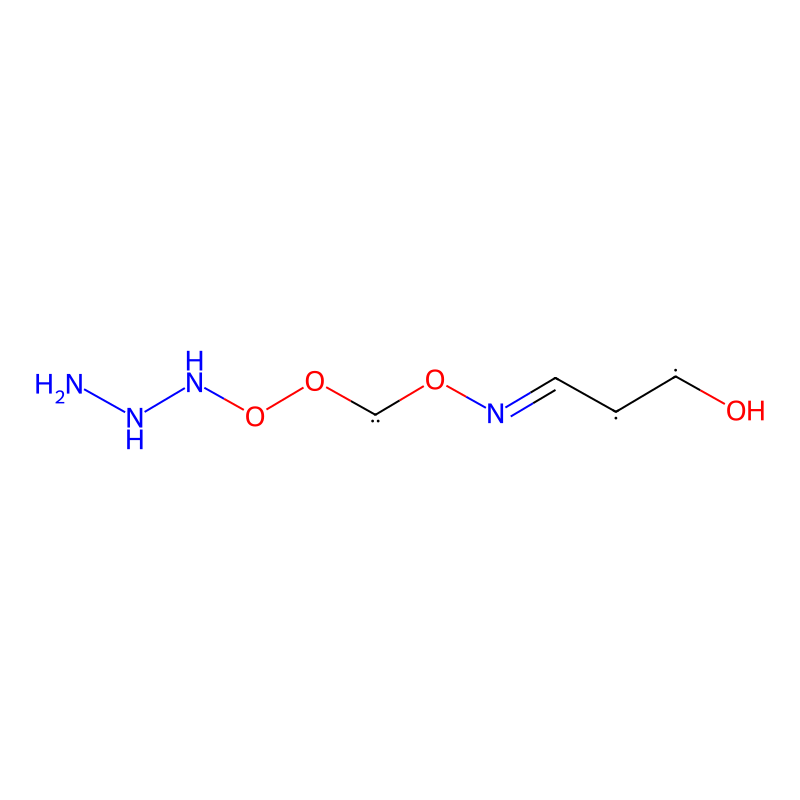

In [46]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = []
for selfie in selfies_out:
    smile = sf.decoder(selfie, attribute=False)
    smiles.append(smile)

ms = []
for smile in smiles:
    ms.append(Chem.MolFromSmiles(smile))
Draw.MolToImage(ms[5], size=(800, 800), kekulize=True)